In [5]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

Text(0.5, 1.0, "Otsu's Binarization")

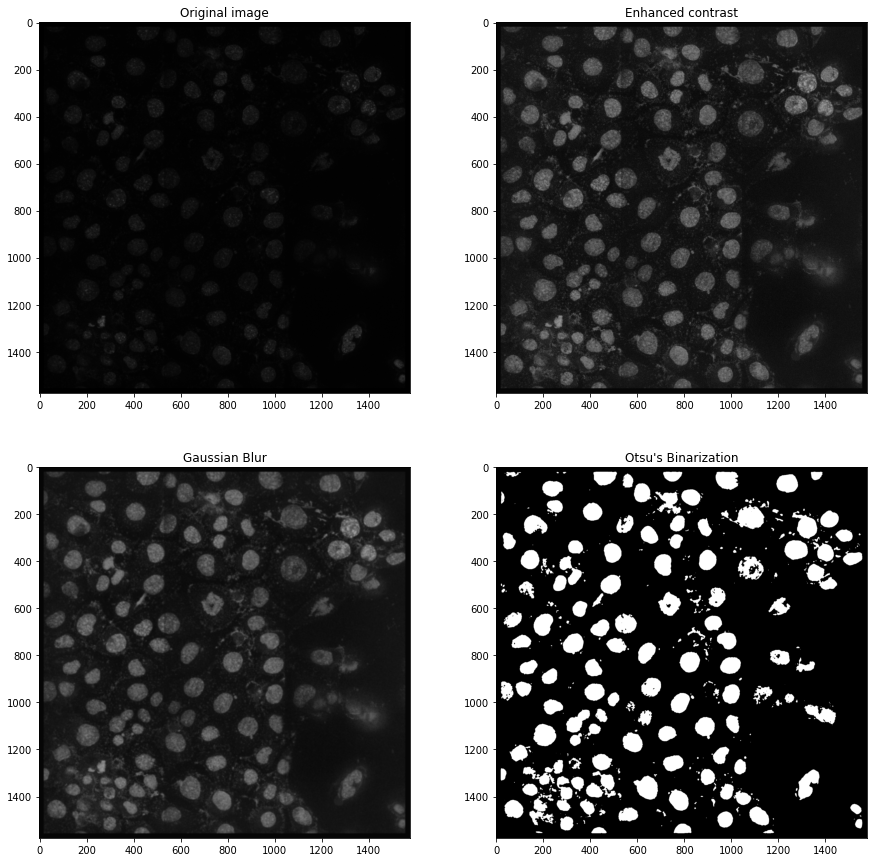

In [17]:
PIXELS_BORDER = 20

# Load nuclei img
nuclei_path = '../data/AKT1_B1_CAn.tif'
#nuclei_path = '../data/ACTN4_L3_NOn.tif'
nuclei_img = cv2.imread(nuclei_path)
nuclei_img_expanded = cv2.copyMakeBorder(nuclei_img, PIXELS_BORDER, PIXELS_BORDER,
                                         PIXELS_BORDER, PIXELS_BORDER, cv2.BORDER_CONSTANT, 0)

nuclei_img_gray = cv2.cvtColor(nuclei_img_expanded, cv2.COLOR_BGR2GRAY)



# Enhance contrast (CLAHE - Contrast Limited Adaptive Histogram Equalization)

clahe = cv2.createCLAHE(clipLimit=5.0)
contrast_img = clahe.apply(nuclei_img_gray)

# Blurring
blur_img = cv2.GaussianBlur(contrast_img, (9,9),0)

# Thresholding (Otsu)
ret, thresh_img = cv2.threshold(blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, axes = plt.subplots(2,2)

axes[0, 0].imshow(nuclei_img_expanded, cmap='gray', vmin=0, vmax=255)
axes[0, 0].set_title('Original image')

axes[0, 1].imshow(contrast_img, cmap='gray', vmin=0, vmax=255)
axes[0, 1].set_title('Enhanced contrast')

axes[1, 0].imshow(blur_img, cmap='gray', vmin=0, vmax=255)
axes[1, 0].set_title('Gaussian Blur')

axes[1, 1].imshow(thresh_img, cmap='gray', vmin=0, vmax=255)
axes[1, 1].set_title("Otsu's Binarization")

Text(0.5, 1.0, 'Unknown')

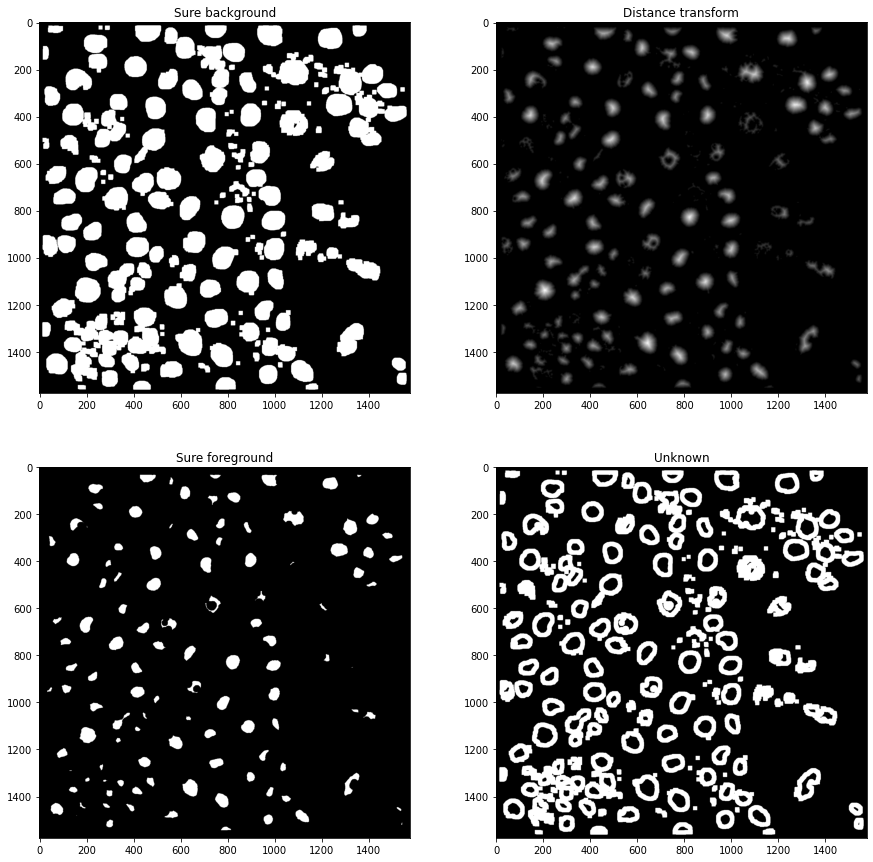

In [18]:
# Noise removal
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel, iterations=1)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

fig, axes = plt.subplots(2,2)

axes[0, 0].imshow(sure_bg, cmap='gray', vmin=0, vmax=255)
axes[0, 0].set_title('Sure background')

axes[0, 1].imshow(dist_transform, cmap='gray')
axes[0, 1].set_title('Distance transform')

axes[1, 0].imshow(sure_fg, cmap='gray', vmin=0, vmax=255)
axes[1, 0].set_title("Sure foreground")

axes[1, 1].imshow(unknown, cmap='gray', vmin=0, vmax=255)
axes[1, 1].set_title("Unknown")

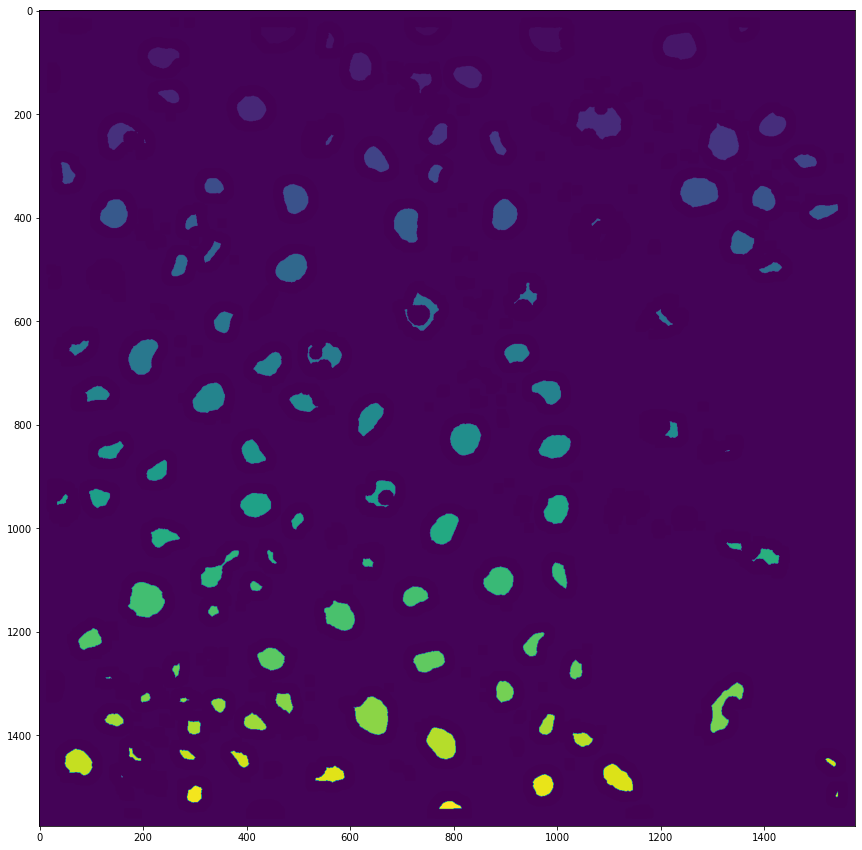

In [19]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

fig, ax = plt.subplots()
ax.imshow(markers)

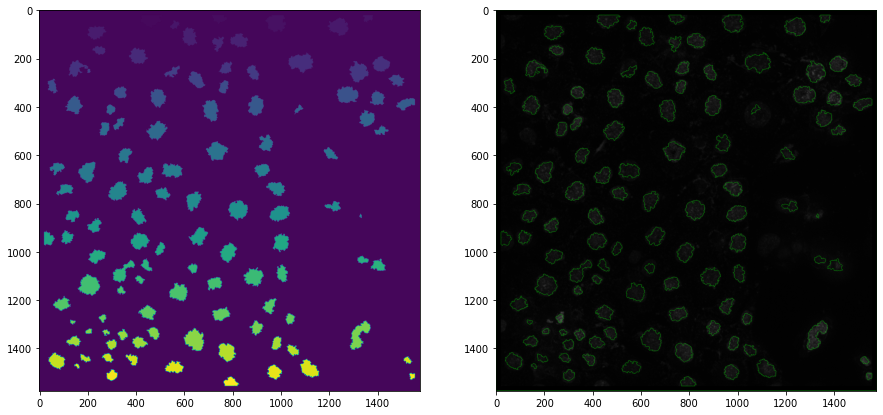

In [20]:
markers_watershed = cv2.watershed(nuclei_img_expanded, markers)
segmented_img = nuclei_img_expanded.copy()
segmented_img[markers_watershed == -1] = [0,255,0]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(markers_watershed)
ax[1].imshow(segmented_img)

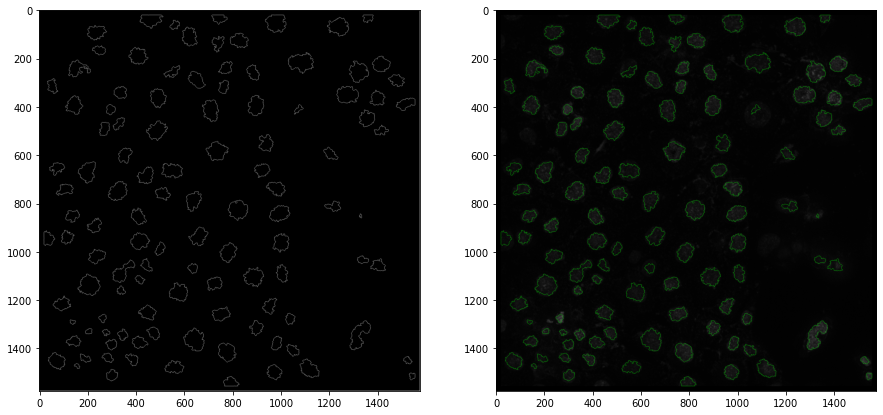

In [21]:
contours_img = np.zeros(markers_watershed.shape, dtype='uint8')
contours_img[markers_watershed == -1] = 255

img2 = nuclei_img_expanded.copy()
contours, hierarchy = cv2.findContours(contours_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)    
for c in contours[:-2]:
    cv2.drawContours(img2, c, -1, (0, 255, 0), 0)
    
fig, ax = plt.subplots(1, 2)


ax[0].imshow(contours_img, cmap='gray')
ax[1].imshow(img2)


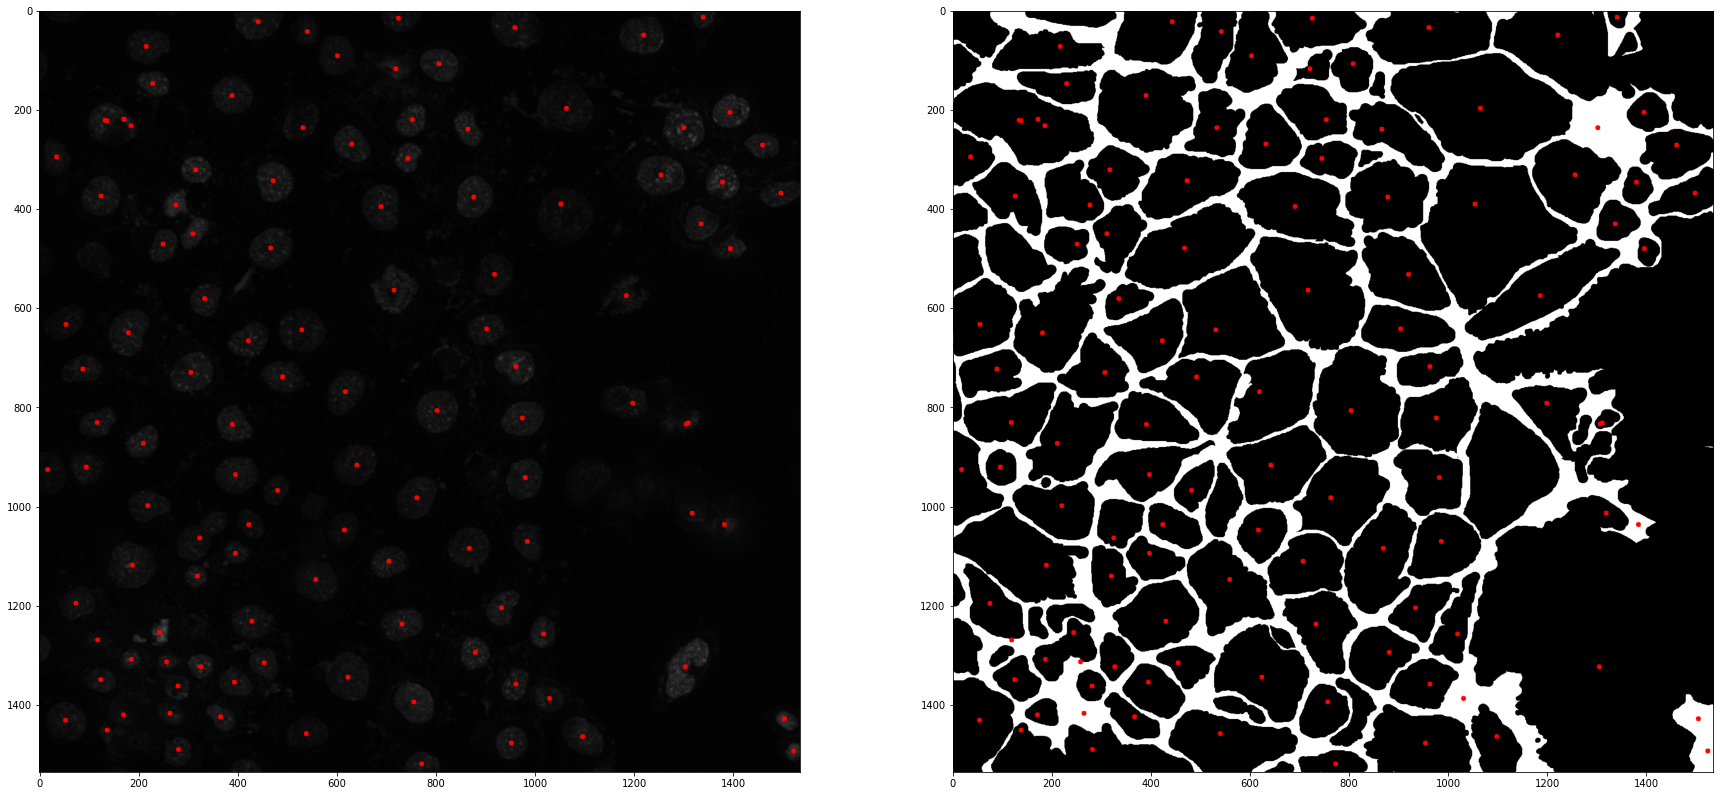

In [23]:
jbin_path = '../data/AKT1_B1_CAj-BI.tif'
jbin_img = cv2.imread(jbin_path)


centroids = []

contours = contours[:-2]
img_centroids = nuclei_img.copy()
bin_centroids = jbin_img.copy()

for c in contours:
    moments = cv2.moments(c)
    area = moments['m00']
    cX = int(moments['m10'] / area) - PIXELS_BORDER
    cY = int(moments['m01'] / area) - PIXELS_BORDER
    cv2.circle(img_centroids, (cX, cY), 5, (255, 0, 0), -1)
    cv2.circle(bin_centroids, (cX, cY), 5, (255, 0, 0), -1)
    centroids.append((cX, cY))
    
centroids = np.array(centroids, dtype=int)
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
ax[0].imshow(img_centroids)
ax[1].imshow(bin_centroids)

In [28]:
centroids.shape

(261, 2)

In [31]:
def get_nuclei_centroids(nuclei_img):
    PIXELS_BORDER = 20

    nuclei_img_expanded = cv2.copyMakeBorder(nuclei_img, PIXELS_BORDER, PIXELS_BORDER,
                                             PIXELS_BORDER, PIXELS_BORDER, cv2.BORDER_CONSTANT, 0)

    nuclei_img_gray = cv2.cvtColor(nuclei_img_expanded, cv2.COLOR_BGR2GRAY)

    # Enhance contrast (CLAHE - Contrast Limited Adaptive Histogram Equalization)

    clahe = cv2.createCLAHE(clipLimit=5.0)
    contrast_img = clahe.apply(nuclei_img_gray)

    # Blurring
    blur_img = cv2.GaussianBlur(contrast_img, (9,9),0)

    # Thresholding (Otsu)
    ret, thresh_img = cv2.threshold(blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Noise removal
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel, iterations=1)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    
    markers_watershed = cv2.watershed(nuclei_img_expanded, markers)
    
    contours_img = np.zeros(markers_watershed.shape, dtype='uint8')
    contours_img[markers_watershed == -1] = 255

    contours, hierarchy = cv2.findContours(contours_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)    
    
    centroids = []

    contours = contours[:-2]
    for c in contours:
        moments = cv2.moments(c)
        area = moments['m00']
        cX = int(moments['m10'] / area) - PIXELS_BORDER
        cY = int(moments['m01'] / area) - PIXELS_BORDER
        centroids.append((cX, cY))

    centroids = np.array(centroids, dtype=int)
    
    return centroids

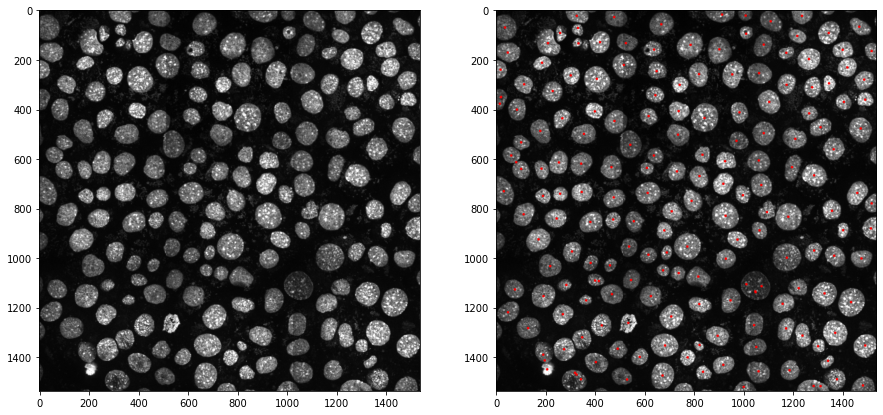

In [32]:
path = 'mltest/ACTR3_C3_NOn.tif'
img = cv2.imread(path)
centroids = get_nuclei_centroids(img)

img_centroids = img.copy()
for x, y in centroids:
    cv2.circle(img_centroids, (x, y), 5, (255, 0, 0), -1)
    
fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(img_centroids)